# Visualize topographic and climatic distributions per land use class

In [135]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns

In [49]:
file_path = Path('/Users/wmk934/data/perceptual_models/data/zonal_stats/')
dat_file_name = 'zonal_stats.csv'
shp_file_name = 'merit_hydro_basins_MODIS_IGBP_counts.shp'

In [50]:
dat = pd.read_csv(file_path/dat_file_name)

In [53]:
shp = gpd.read_file(file_path/shp_file_name)

In [ ]:
# Merge the whole thing so we can look at geographical locations
dat = dat.set_index('COMID')
shp = shp.set_index('COMID')
assert (dat.index == shp.index).all() # pops an error if index (COMID) order is not the same in both dataframes
dat['geometry'] = shp['geometry']
dat = gpd.GeoDataFrame(dat)

In [73]:
# Get some borders for context
border_path = Path('/Users/wmk934/data/Global_geospatial/borders/world-administrative-boundaries')
border_file = 'world-administrative-boundaries.shp'
borders = gpd.read_file(border_path/border_file)

In [85]:
nab = borders[(borders['iso3'] == 'USA') | (borders['iso3'] == 'CAN') | (borders['iso3'] == 'MEX')].copy().reset_index(drop=True)

### Assess climate and topo per broad land use class

In [98]:
# Image save location
save_path = Path('/Users/wmk934/data/perceptual_models/img')

In [178]:
mapping_dict = {'igbp_1' : 'Evergreen Needleleaf Forests', # Dominated by evergreen conifer trees (canopy >2m). Tree cover >60%.
                'igbp_2' : 'Evergreen Broadleaf Forests',  # Dominated by evergreen broadleaf and palmate trees (canopy >2m). Tree cover >60%.
                'igbp_3' : 'Deciduous Needleleaf Forests', # Dominated by deciduous needleleaf (larch) trees (canopy >2m). Tree cover >60%.
                'igbp_4' : 'Deciduous Broadleaf Forests',  # Dominated by deciduous broadleaf trees (canopy >2m). Tree cover >60%.
                'igbp_5' : 'Mixed Forests',                # Dominated by neither deciduous nor evergreen (40-60% of each) tree type (canopy >2m). Tree cover >60%.
                'igbp_6' : 'Closed Shrublands',            # Dominated by woody perennials (1-2m height) >60% cover.
                'igbp_7' : 'Open Shrublands',              # Dominated by woody perennials (1-2m height) 10-60% cover.
                'igbp_8' : 'Woody Savannas',               # Tree cover 30-60% (canopy >2m).
                'igbp_9' : 'Savannas',                     # Tree cover 10-30% (canopy >2m).
                'igbp_10': 'Grasslands',                   # Dominated by herbaceous annuals (<2m).
                'igbp_11': 'Permanent Wetlands',           # Permanently inundated lands with 30-60% water cover and >10% vegetated cover.
                'igbp_12': 'Croplands',                    # At least 60% of area is cultivated cropland.
                'igbp_13': 'Urban and Built-up Lands',     # At least 30% impervious surface area including building materials, asphalt, and vehicles.
                'igbp_14': 'Cropland/Natural Vegetation Mosaic', # Mosaics of small-scale cultivation 40-60% with natural tree, shrub, or herbaceous vegetation.
                'igbp_15': 'Permanent Snow/Ice',           # At least 60% of area is covered by snow and ice for at least 10 months of the year.
                'igbp_16': 'Barren',                       # At least 60% of area is non-vegetated barren (sand, rock, soil) areas with less than 10% vegetation.
                'igbp_17': 'Water Bodies'}                 # At least 60% of area is covered by permanent water bodies.
                #'igbp_255': 'Unclassified'} # Skip this, because we know we don't have that in this data set

In [114]:
# Variables for which we want to plot histograms
variables = ['elev_mean','slope_mean','',
             'im_mean','imr_mean','fs_mean',
             'lgrip','igbp','depth_mean']
variables_leg = ['elevation [m.a.s.l.]','slope [degrees]','',
                 'aridity Im [-]','seasonality Imr [-]','snow fs [-]',
                 'agri class [-]', 'igbp class [-]', 'soil depth [m]']

In [170]:
def plot_categorical_histogram(cat, df, ax, mask, basin):
    '''Converts columns with categorical data counts in a dataframe into a histogram'''
    
    # Define what we're working with
    if cat == 'lgrip':
        columns = ['lg_water', 'lg_non-cro', 'lg_irrigat', 'lg_rainfed']
        labels  = ['Water', 'Non-cropland', 'Irrigated', 'Rain-fed']
        tick_labels = labels # Need this so we can use different ticks for IGBP
        rotation = 35
        align = 'right'
    elif cat == 'igbp':
        columns = ['igbp_1', 'igbp_2', 'igbp_3', 'igbp_4', 'igbp_5',
                   'igbp_6', 'igbp_7', 'igbp_8', 'igbp_9', 'igbp_10', 'igbp_11', 'igbp_12',
                   'igbp_13', 'igbp_14', 'igbp_15', 'igbp_16', 'igbp_17']#, 'igbp_255'] # skip 255 becaue we know we have no 255 values in this dataset
        labels = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17'] #,'255']
        tick_labels = ['1','','3','','5','','7','','9','','11','','13','','15','','17'] # Need to skip half for space reasons
        rotation = 90
        align = 'center'
    else:
        print(f'Cateogry {cat} not defined')
        return

    # Find what we're plotting 
    data_all = {}
    for column,label in zip(columns,labels):
        data_all[label] = df[column].sum()
    data_mask = {}
    for column,label in zip(columns,labels):
        data_mask[label] = df[mask][column].sum()

    # Make the plot
    ax.bar(data_all.keys(),  data_all.values(), width=1, label='all') # width=1 eliminates gaps between bars
    ax.bar(data_mask.keys(), data_mask.values(), width=1,label=basin)
    ax.set_xticks(range(0,len(data_all.keys()))) # Needed because we otherwise get a warning
    ax.set_xticklabels(tick_labels, rotation=rotation, ha=align)

    return ax

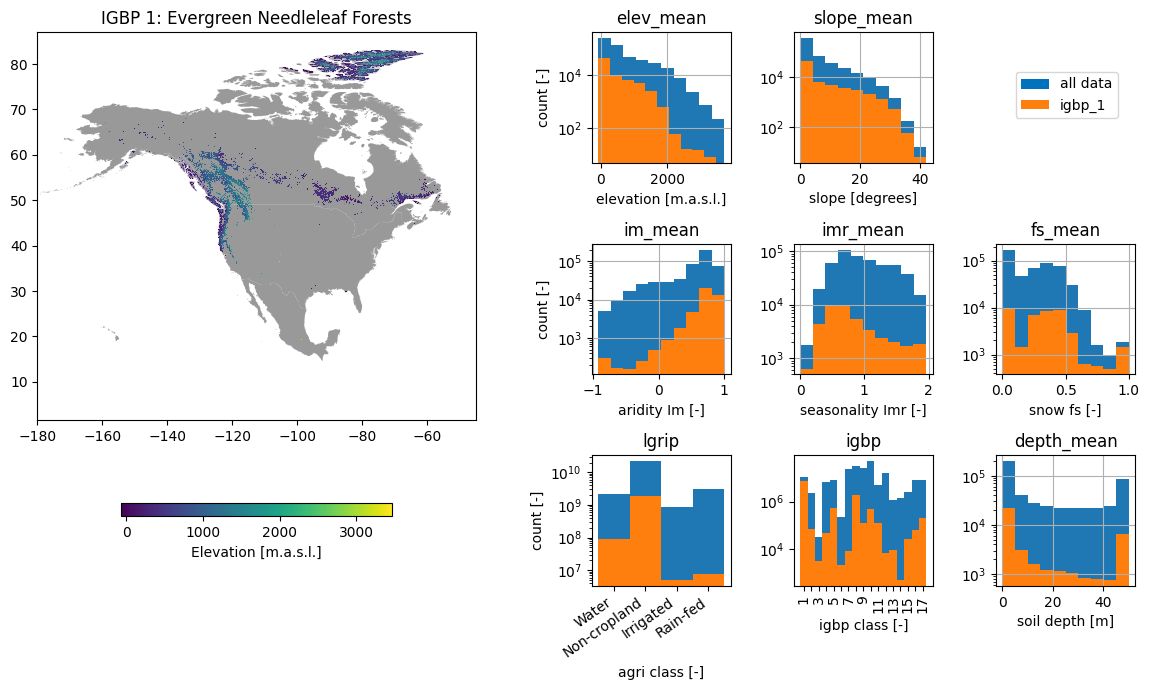

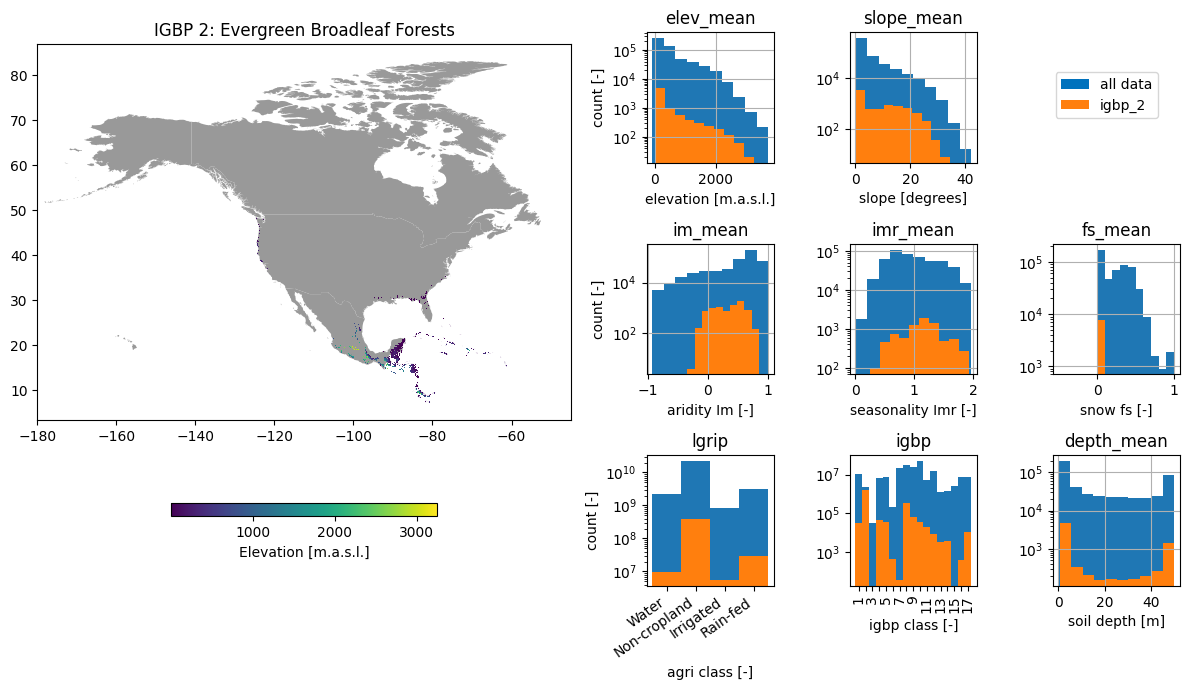

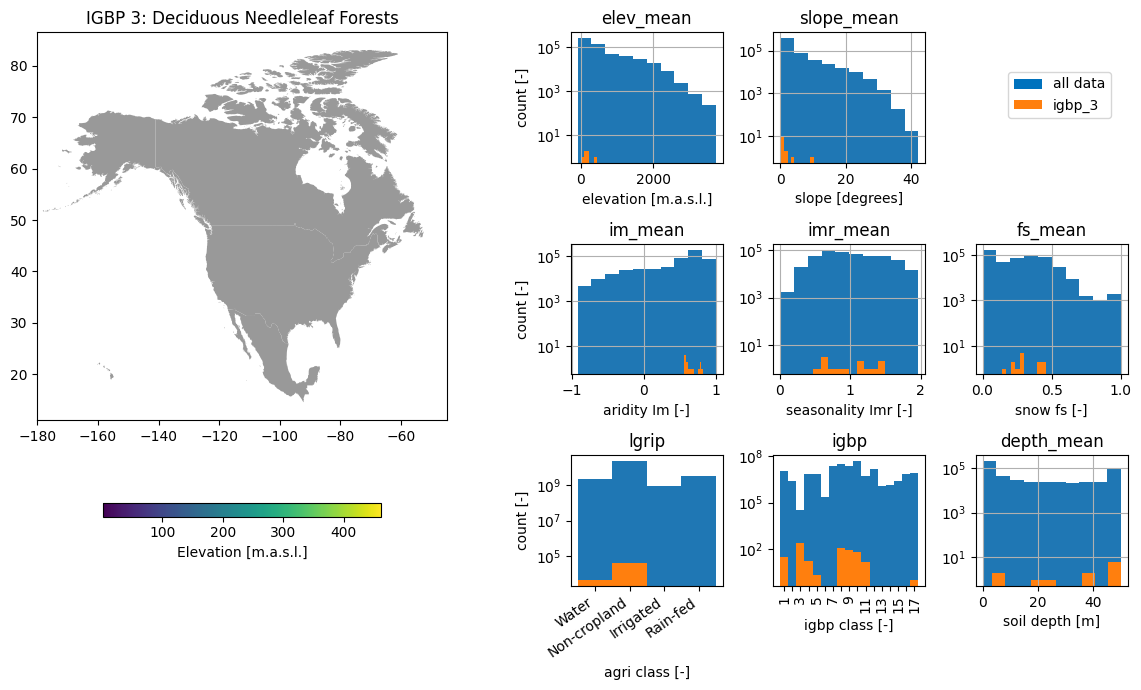

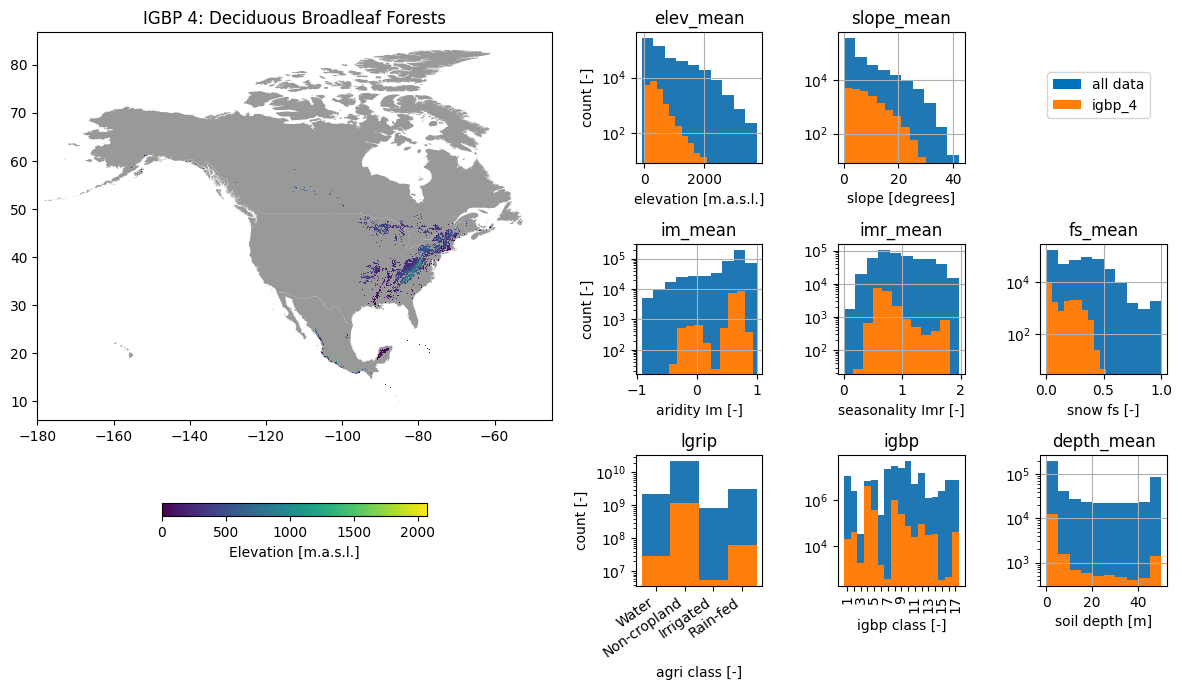

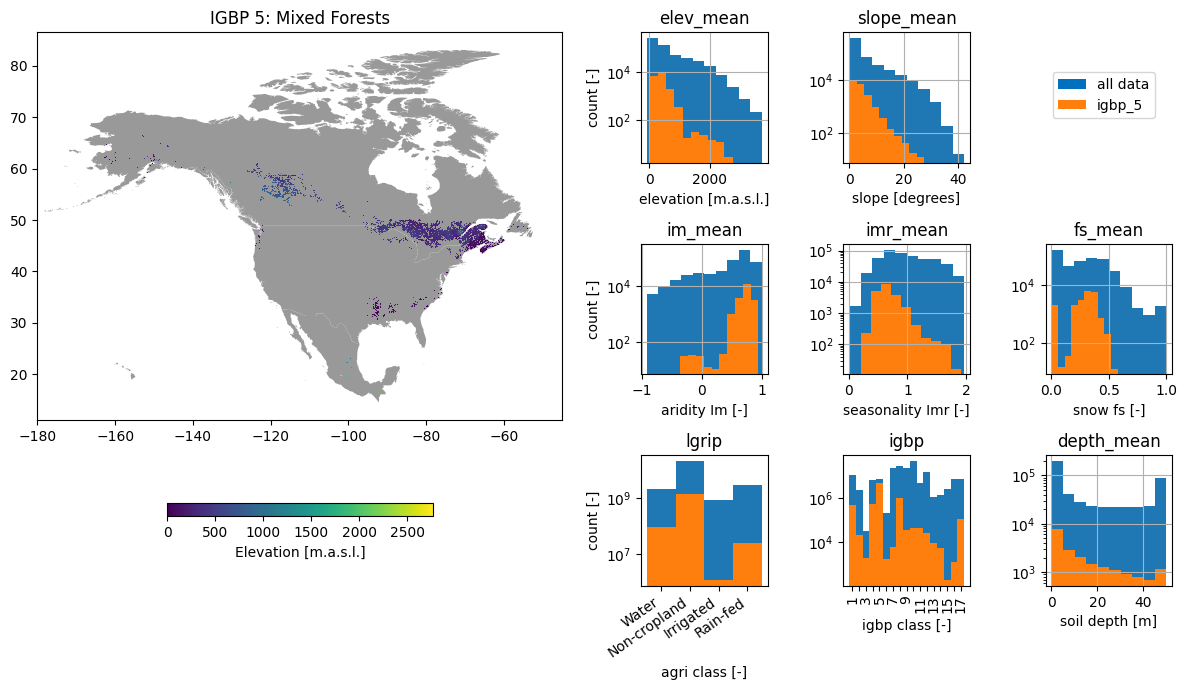

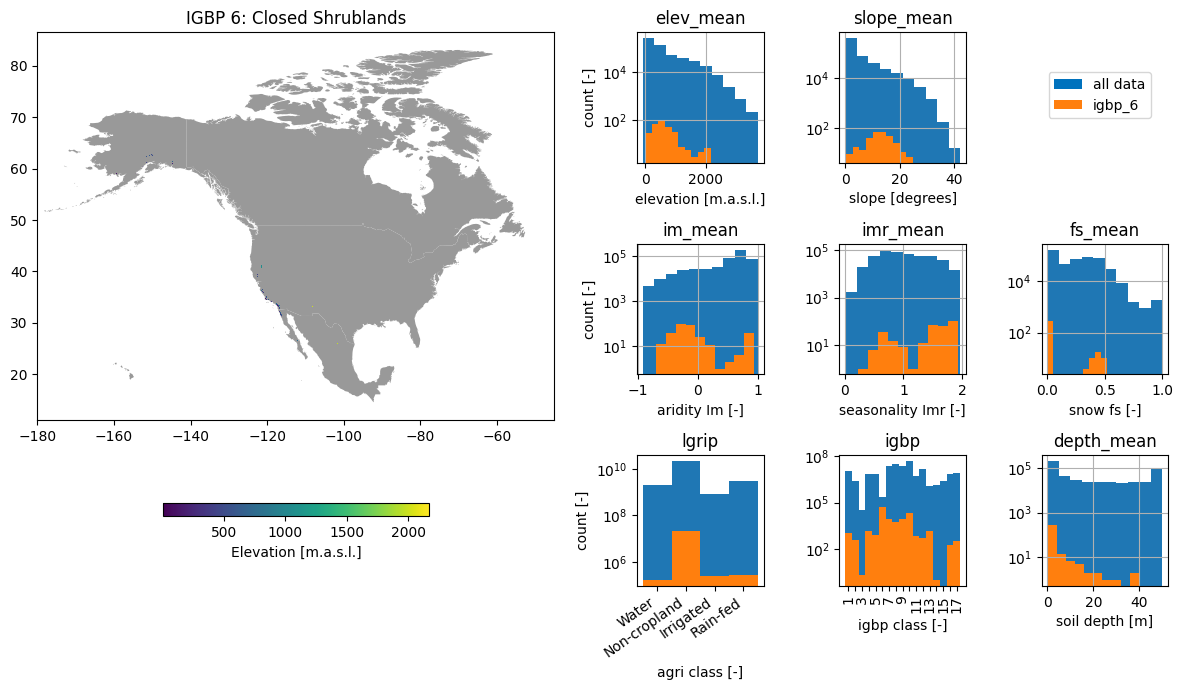

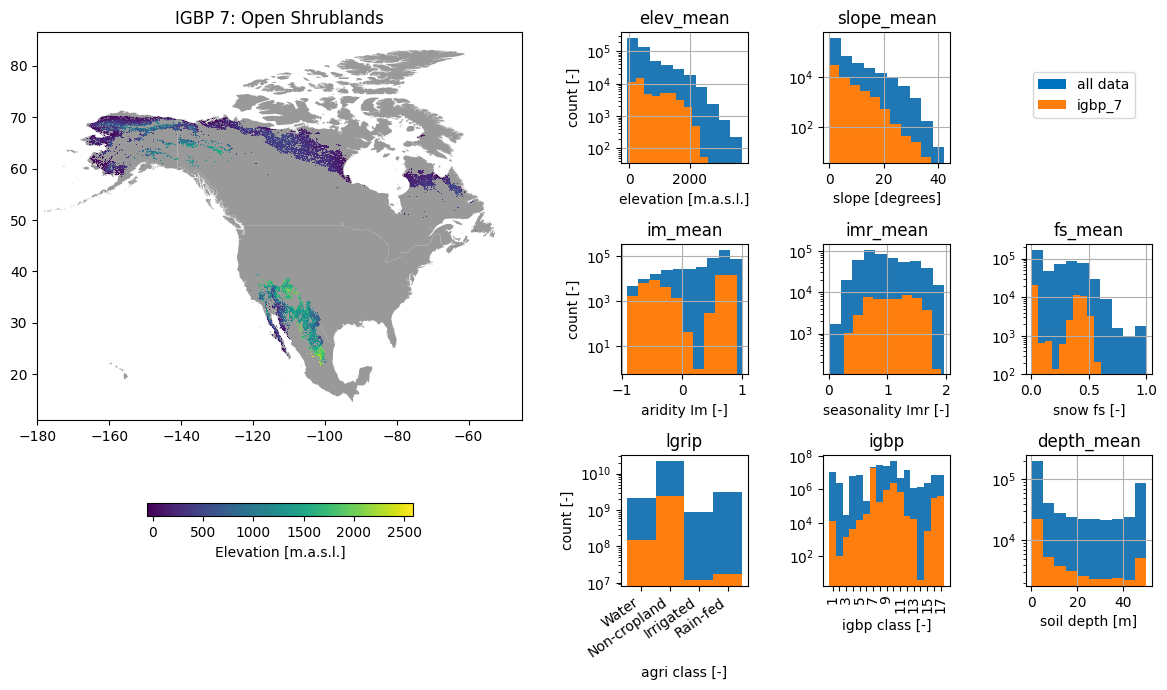

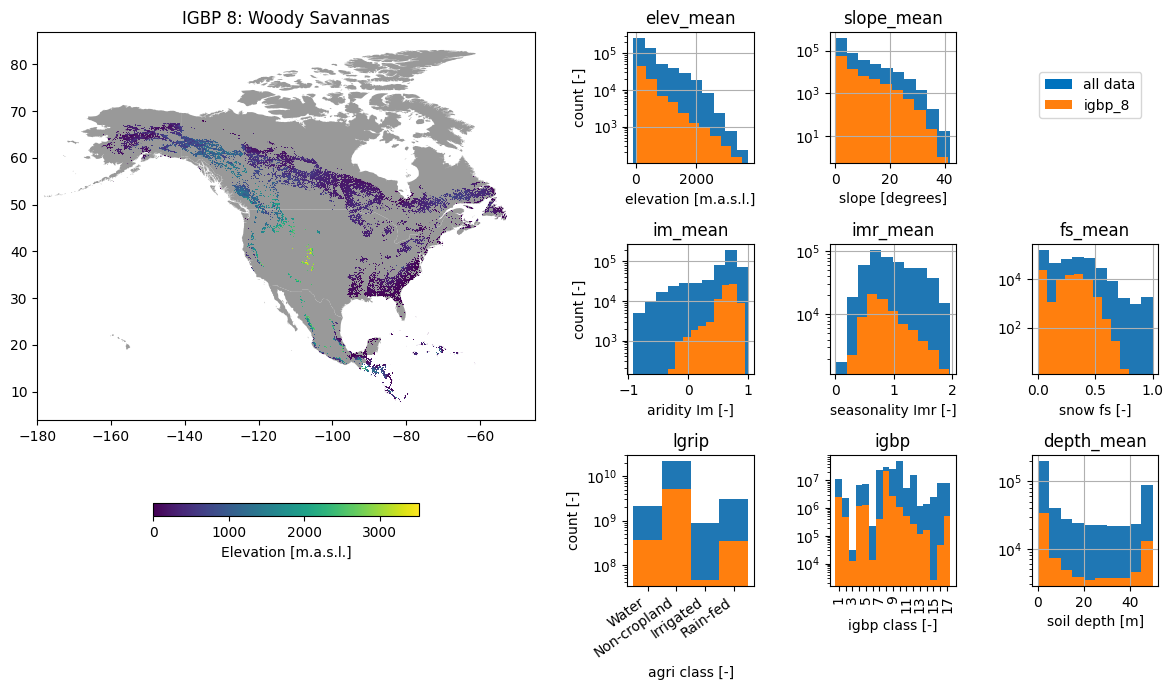

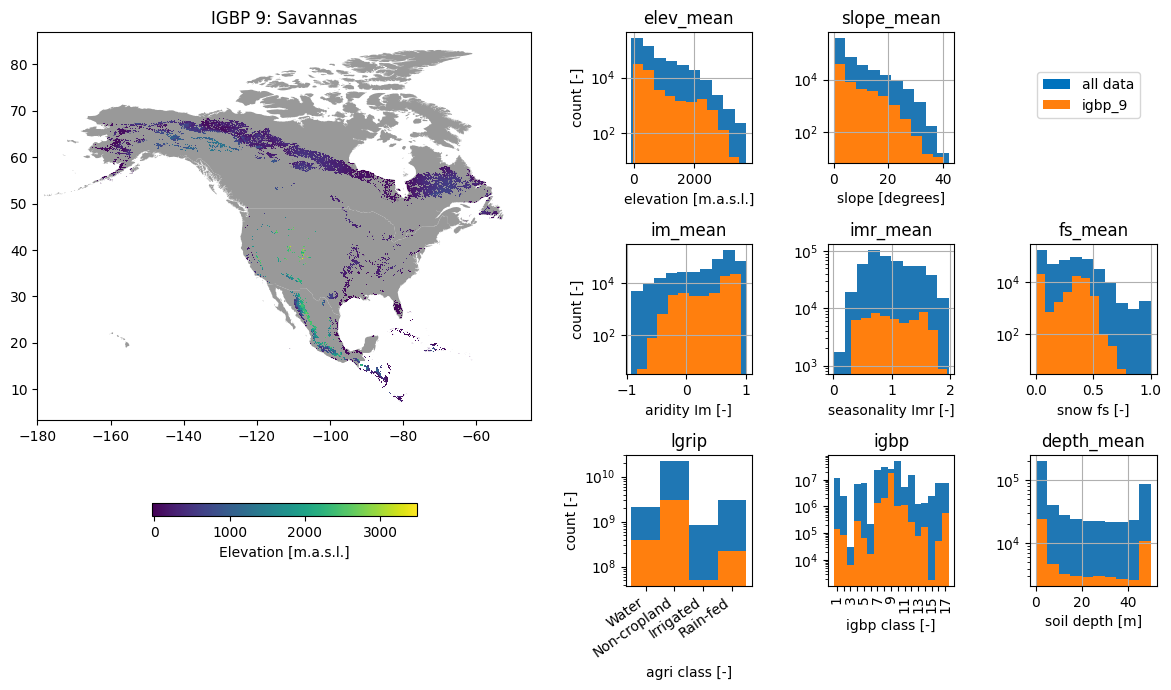

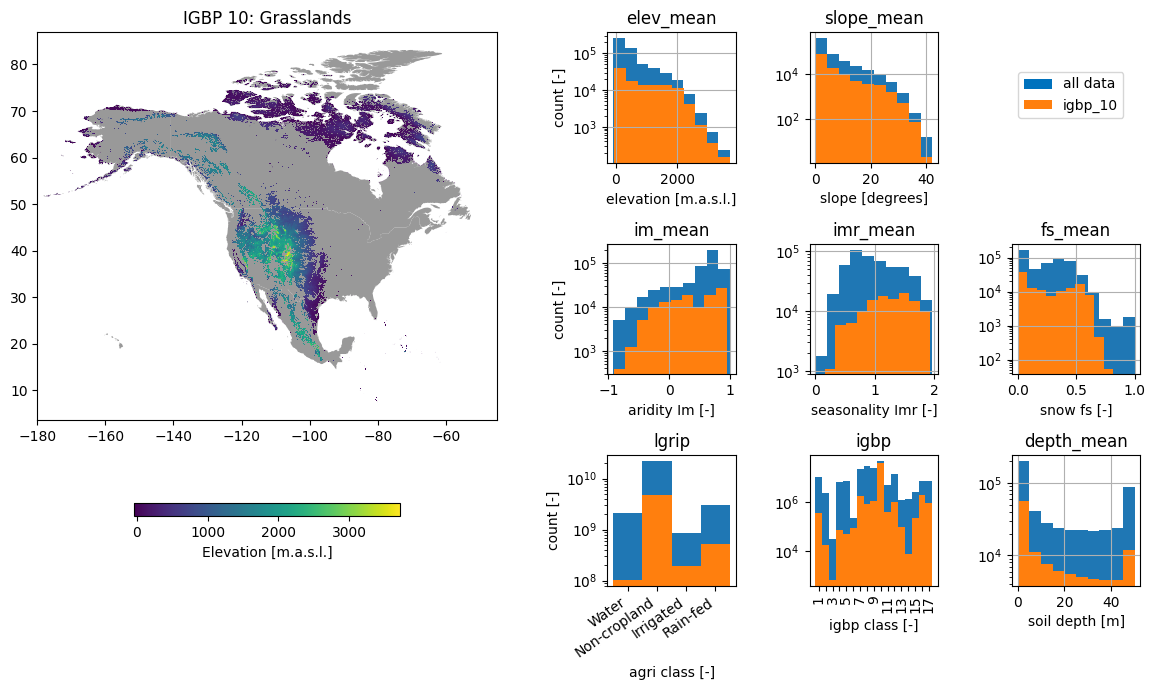

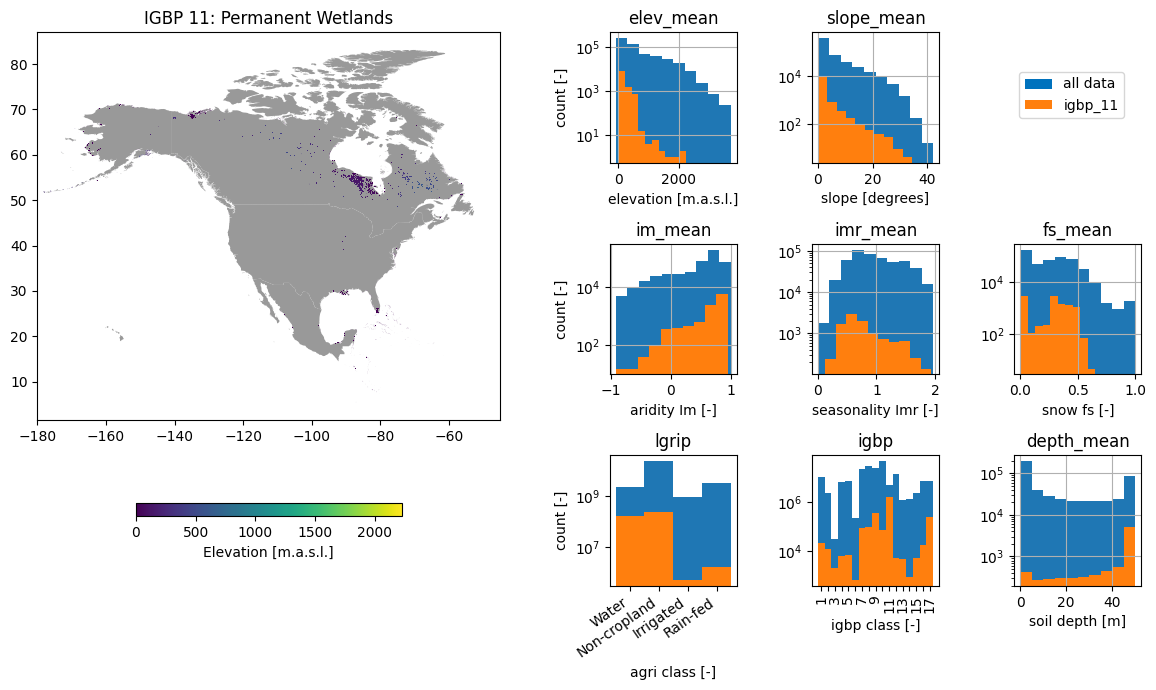

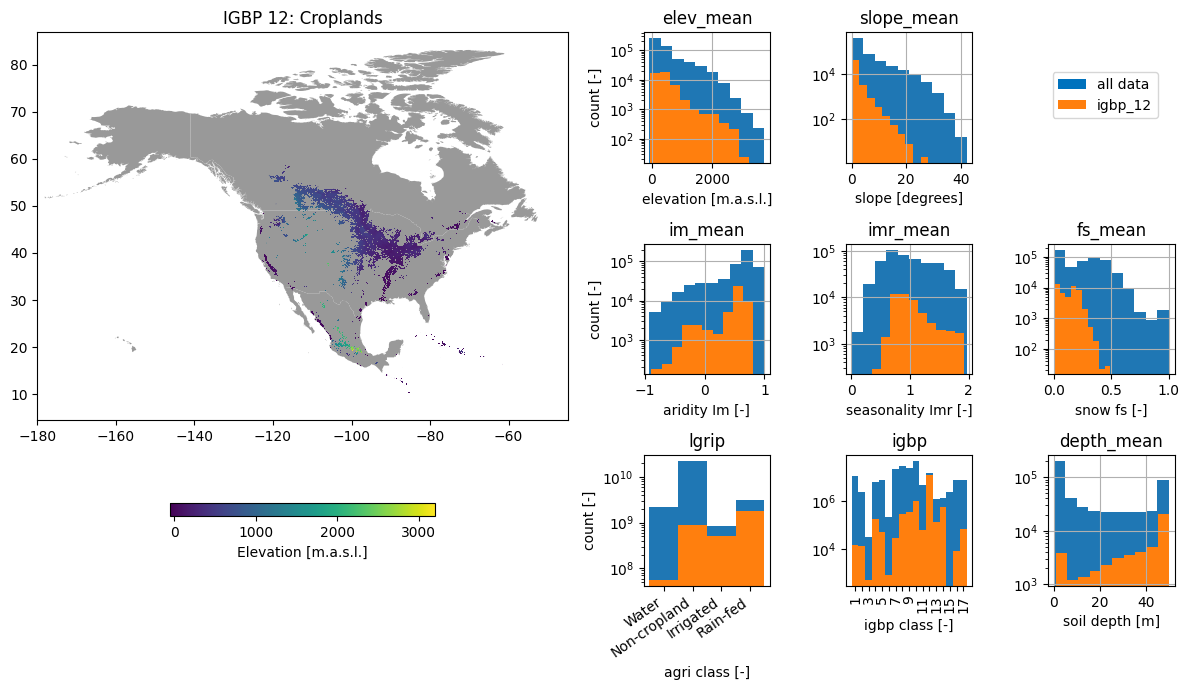

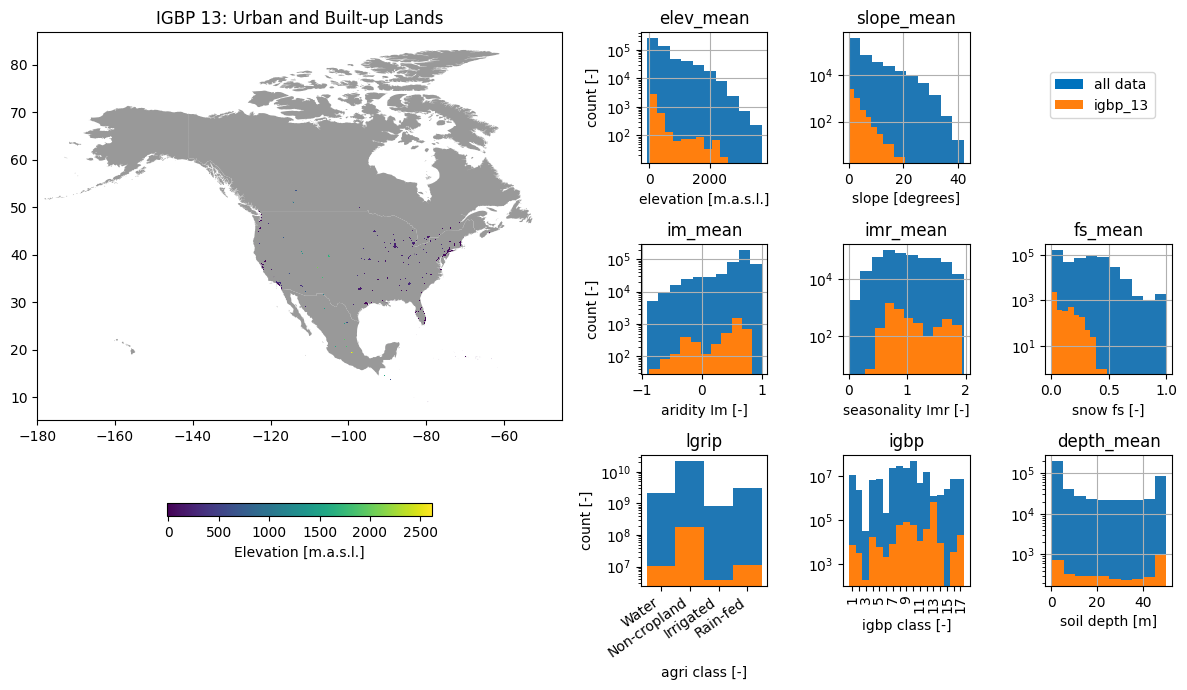

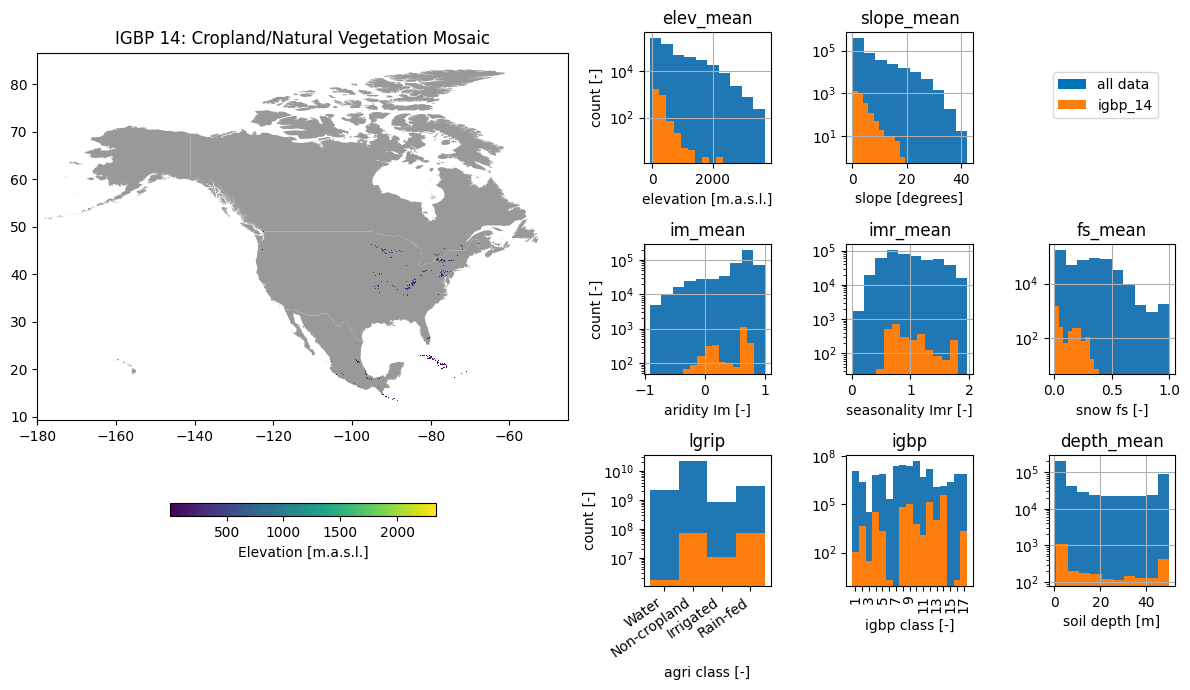

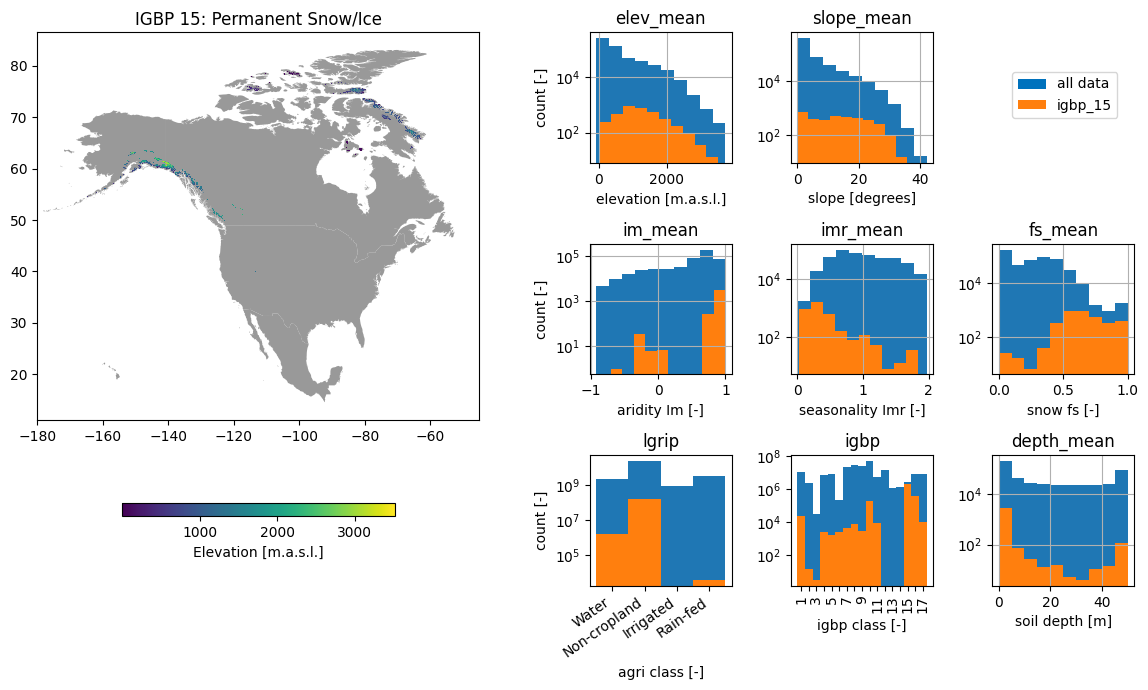

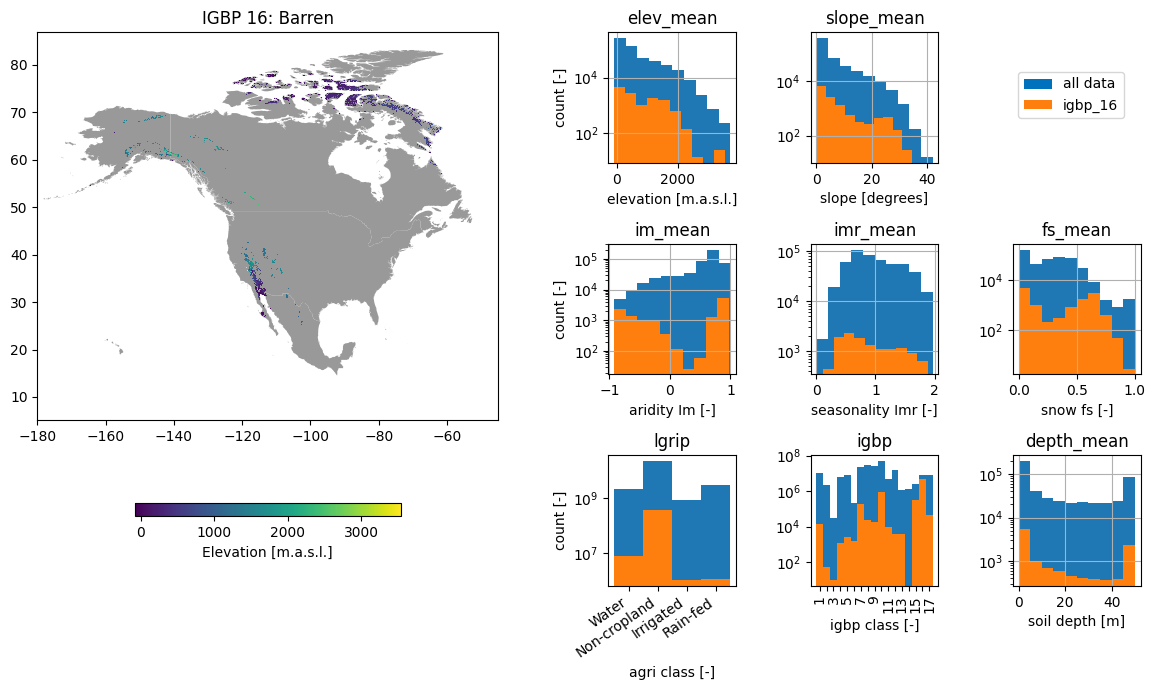

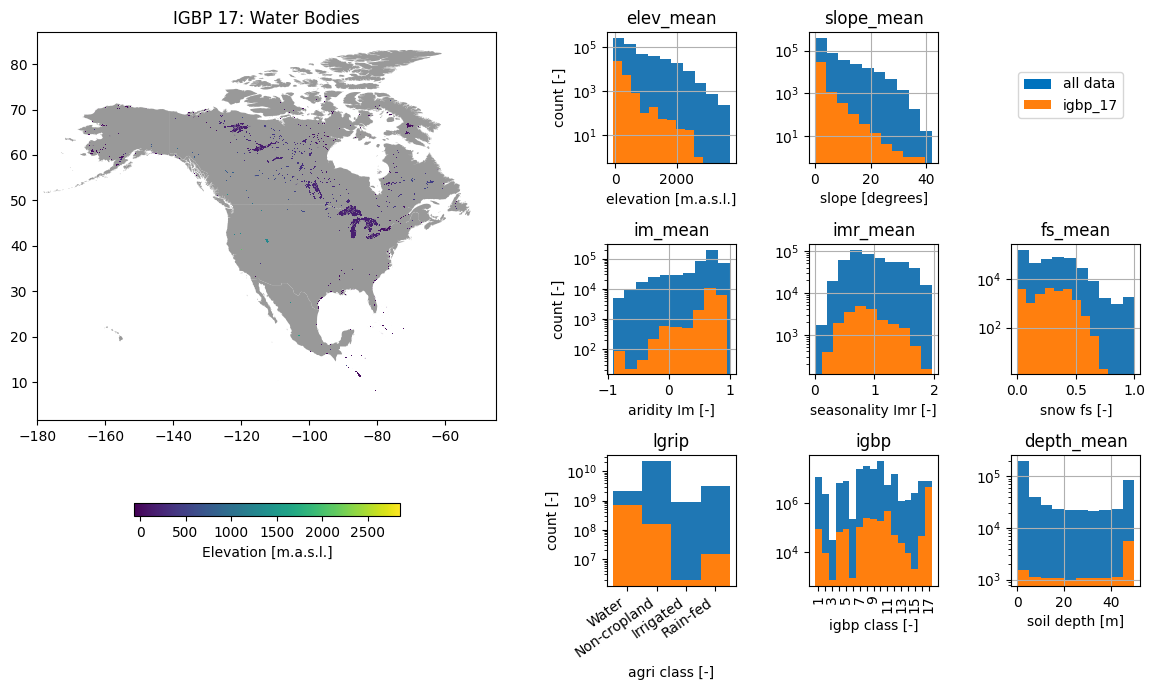

In [179]:
# Loop over the classes and create map + histograms
for key,val in mapping_dict.items():
    
    # Subset to basins that mostly have this land cover class
    igbp_class = int( key.split('_')[-1] )
    mask = dat['igbp_mode'] == igbp_class

    fig = plt.figure(figsize=(12, 7))

    # Create a large map on the left half
    ax_large = plt.subplot2grid((3, 6), (0, 0), rowspan=3, colspan=3)
    nab.plot(ax=ax_large,color='0.6')
    dat[mask].plot(ax=ax_large, column='elev_mean', legend=True, 
                   legend_kwds={
                       'shrink':.5, 
                       'orientation':'horizontal',
                       'label':'Elevation [m.a.s.l.]'
                   })
    ax_large.set_xlim([-180,-45])
    ax_large.set_title(f'IGBP {igbp_class}: {val}')

    # Create smaller histograms on the right half
    ii = [0,0,0,1,1,1,2,2,2]
    jj = [0,1,2,0,1,2,0,1,2]
    for i,j,var,var_lbl in zip(ii,jj,variables,variables_leg):
        ax = plt.subplot2grid((3, 6), (i, j+3))
        if var == '':
                ax.set_visible(False) # No data here, so hide the axis
                continue
        if (var == 'lgrip') or (var == 'igbp'): # Build a histogram for categorical data
            ax = plot_categorical_histogram(var, dat, ax, mask, key)        
        else:  
            dat[var].hist(ax=ax, label='all')
            dat[mask][var].hist(ax=ax, label=key)
        
        # Junk
        if j == 0: ax.set_ylabel('count [-]')
        ax.set_yscale('log')
        ax.set_xlabel(var_lbl)
        ax.set_title(f'{var}')
    
    # Create custom legend elements
    legend_elements = [
        Patch(facecolor=[0, 0.447, 0.741], edgecolor='None', label='all data'),
        Patch(facecolor=[1.0, 0.49803922, 0.05490196], edgecolor='None', label=f'{key}')
    ]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.975, 0.90))
    
    plt.tight_layout()
    plt.savefig(save_path / f'descriptors_by_IGBP_{key}.png', dpi=300, bbox_inches='tight')